In [1]:
%reset -f
# Sheet metal gauge reference: https://armstrongmetalcrafts.com/reference/SheetMetalGaugeWeight.aspx

# Manufacturing capabilities per value stream @ BAC
This code shows conservative boundaries for the allowed dimensions in each manufacturing value stream.

In [2]:
from capabilities import Capabilities
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xlwings as xw
import os
for app in xw.apps: app.quit()

regions = ['TL', 'MPB', 'APB']
part_set_names = ['HT', 'WC', 'WD', 'AH', 'SA']

all_stats = {
    name: {
        'total_parts': 0,
        'unique_part_counts': {region: 0 for region in regions},
        'unique_part_percentages': {region: 0 for region in regions},
        'total_weight': 0,
        'weight_counts': {region: 0 for region in regions},
        'weight_percentages': {region: 0 for region in regions},
    }
    for name in part_set_names
}

Extracting dimensions from cost calculator. CWB example to start with.

In [3]:
path_e = r"C:\Users\EMedina\OneDrive - Baltimore Aircoil Company\Documents\Co-Op\Enrique + Stanley\Models\Cost\Cost Calculator Per SM.xlsx"
path_s = r"C:\Users\ssalim\OneDrive - Baltimore Aircoil Company\Medina, Enrique Flores's files - Enrique + Stanley\Models\Cost\Cost Calculator Per SM.xlsx"
path = path_e if os.path.exists(path_e) else path_s
df = pd.read_excel(path, sheet_name='BAC Part List').iloc[1:].reset_index(drop=True)
df.columns = df.iloc[0]
df = df.iloc[1:].reset_index(drop=True)

c:\Users\EMedina\AppData\Local\anaconda3\envs\BAC\Lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


In [11]:
def get_parts_by_set(df, part_set):
    if isinstance(part_set, str): part_set = [part_set]
    return df[df['Part Set'].isin(part_set)].copy()

def get_part_stats(local_stats):
    for region_stats in local_stats:
        for part_set_name in region_stats:
            all_stats[part_set_name]['total_parts'] += region_stats[part_set_name]['total_parts']
            all_stats[part_set_name]['total_weight'] += region_stats[part_set_name]['total_weight']
            for region in regions:               
                all_stats[part_set_name]['unique_part_counts'][region] += region_stats[part_set_name]['unique_part_counts'][region]
                all_stats[part_set_name]['weight_counts'][region] += region_stats[part_set_name]['weight_counts'][region]

    for part_set_name, stats in all_stats.items():
        total_parts = stats['total_parts']
        total_weight = stats['total_weight']
        unique_part_percentages = {}
        weight_percentages = {}
        for region in regions:
            unique_part_counts = stats['unique_part_counts'][region]
            unique_part_percentages[region] = (unique_part_counts / total_parts * 100) if total_parts > 0 else 0.0
            all_stats[part_set_name]['unique_part_percentages'] = unique_part_percentages
            weight_counts = stats['weight_counts'][region]
            weight_percentages[region] = (weight_counts / total_weight * 100) if total_weight > 0 else 0.0
            all_stats[part_set_name]['weight_percentages'] = weight_percentages
            
def plot_pie_chart(data, title):
    region_colors = {
        'APB': '#66c2a5',
        'MPB': '#4f8cd6',
        'TL': '#e74c3c'
    }

    plt.figure(figsize=(8, 6))
    wedges, texts, autotexts = plt.pie(data.values(), labels=None, autopct='%1.1f%%', startangle=0, 
                                      colors=[region_colors[region] for region in data.keys()], 
                                      explode=[0.015] * len(data), textprops={'fontsize': 22, 'fontweight': 'bold'})
    plt.title(title, fontsize=28, fontweight='bold')
    plt.axis('equal')
    
    # Add legend in bottom right corner
    plt.legend(wedges, data.keys(), loc='lower right', bbox_to_anchor=(1, 0))
    
    plt.show()

def plot_stacked_bar_chart(all_stats, title):
    """
    Plot a horizontal stacked bar chart with 3 colors (MPB, APB, TL) for each part set,
    ranked in descending order by MPB weight, and add percentage labels.

    Args:
        all_stats (dict): Dictionary containing stats for each part set.
        title (str): Title of the bar chart.
    """

    # Define regions and their colors
    regions = ['MPB', 'APB', 'TL']
    region_colors = {
        'APB': '#66c2a5',
        'MPB': '#4f8cd6',
        'TL': '#e74c3c'
    }

    # Remove 'HT' from part sets
    filtered_stats = {k: v for k, v in all_stats.items() if k != 'HT'}

    # Rank part sets by MPB weight in descending order
    ranked_part_sets = sorted(
        filtered_stats.keys(),
        key=lambda part_set: filtered_stats[part_set]['weight_counts']['MPB'],
        reverse=False
    )

    # Extract data for the bar chart
    part_sets = ranked_part_sets
    total_weights = [filtered_stats[part_set]['total_weight'] for part_set in part_sets]
    region_weights = {
        region: [filtered_stats[part_set]['weight_counts'][region] for part_set in part_sets]
        for region in regions
    }

    # Create a horizontal stacked bar chart
    y = np.arange(len(part_sets))  # Y-axis positions
    bar_height = 0.6

    fig, ax = plt.subplots(figsize=(10, 8))
    left = np.zeros(len(part_sets))  # Initialize the left position of the bars

    for region in regions:
        ax.barh(
            y, region_weights[region], bar_height,
            label=region, color=region_colors[region],
            left=left
        )
        left += np.array(region_weights[region])  # Update the left position for stacking

    # Add percentage labels to the bars
    for i, part_set in enumerate(part_sets):
        total_weight = total_weights[i]
        if total_weight > 0:
            left_position = 0  # Initialize the left position for centering
            for region in regions:
                region_weight = filtered_stats[part_set]['weight_counts'][region]
                percentage = (region_weight / total_weight) * 100
                if region_weight > 0:
                    # Calculate the center of the current region segment
                    x_position = left_position + region_weight / 2
                    ax.text(
                        x_position, i, f'{percentage:.0f}%', ha='center', va='center', fontsize=14, color='white', fontweight='bold'
                    )
                left_position += region_weight  # Update the left position for the next region

    # Add labels, title, and legend
    ax.set_yticks(y)
    ax.set_xticks([])
    ax.set_yticklabels(part_sets, fontsize=14, fontweight='bold')
    ax.set_xlabel('Weight (lbs)', fontsize=16, fontweight='bold')
    ax.set_title(title, fontsize=18, fontweight='bold')
    ax.legend(title='Mfg Method', fontsize=14, loc='lower right')

    plt.tight_layout()
    plt.show()

part_sets = []
for part_set in df['Part Set'].dropna().unique(): 
    part_sets.append(get_parts_by_set(df, part_set))
# part_sets.append(get_parts_by_set(df, 'GAC Reference (MPB)'))

# Plot manufacturing regions per material and gauge

                                                   AH
total_parts                                         3
unique_part_counts      {'TL': 3, 'MPB': 0, 'APB': 0}
total_weight                                    80.96
weight_counts       {'TL': 80.96, 'MPB': 0, 'APB': 0}
                                                   SA
total_parts                                         3
unique_part_counts      {'TL': 3, 'MPB': 0, 'APB': 0}
total_weight                                    72.56
weight_counts       {'TL': 72.56, 'MPB': 0, 'APB': 0}
                                                   WC
total_parts                                         1
unique_part_counts      {'TL': 1, 'MPB': 0, 'APB': 0}
total_weight                                    44.28
weight_counts       {'TL': 44.28, 'MPB': 0, 'APB': 0}
                                                   WD
total_parts                                         1
unique_part_counts      {'TL': 0, 'MPB': 1, 'APB': 0}
total_weight                

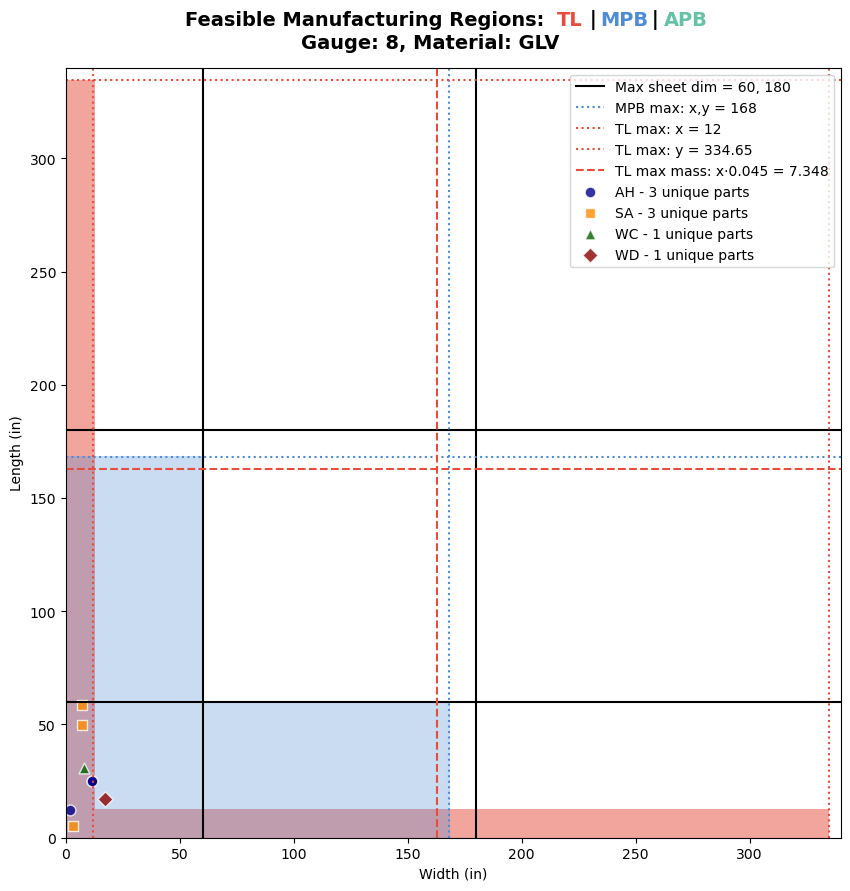

                                                  SA
total_parts                                        1
unique_part_counts     {'TL': 1, 'MPB': 0, 'APB': 0}
total_weight                                    3.04
weight_counts       {'TL': 3.04, 'MPB': 0, 'APB': 0}
                                                       WC
total_parts                                             2
unique_part_counts          {'TL': 1, 'MPB': 1, 'APB': 0}
total_weight                                       130.49
weight_counts       {'TL': 53.81, 'MPB': 76.68, 'APB': 0}


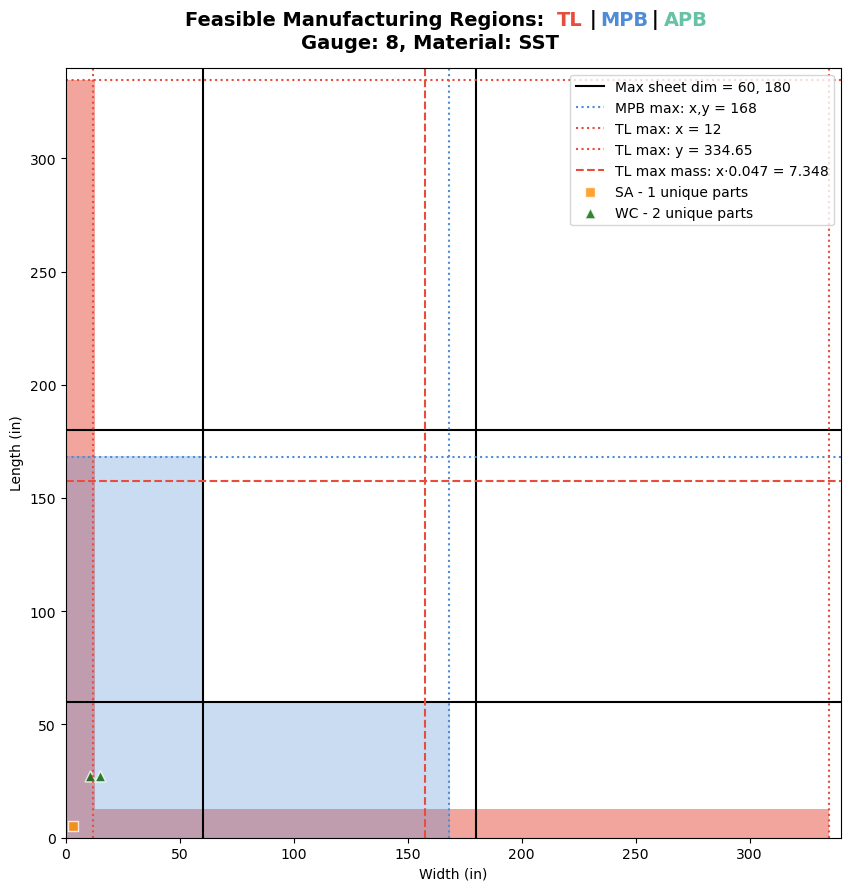

                                                        AH
total_parts                                              5
unique_part_counts           {'TL': 3, 'MPB': 2, 'APB': 0}
total_weight                                        366.24
weight_counts       {'TL': 108.3, 'MPB': 257.94, 'APB': 0}
                                                          SA
total_parts                                               29
unique_part_counts            {'TL': 21, 'MPB': 8, 'APB': 0}
total_weight                                         2670.38
weight_counts       {'TL': 1892.03, 'MPB': 778.35, 'APB': 0}
                                                       WC
total_parts                                             6
unique_part_counts          {'TL': 3, 'MPB': 3, 'APB': 0}
total_weight                                       485.93
weight_counts       {'TL': 89.43, 'MPB': 396.5, 'APB': 0}
                                                   WD
total_parts                                         1
un

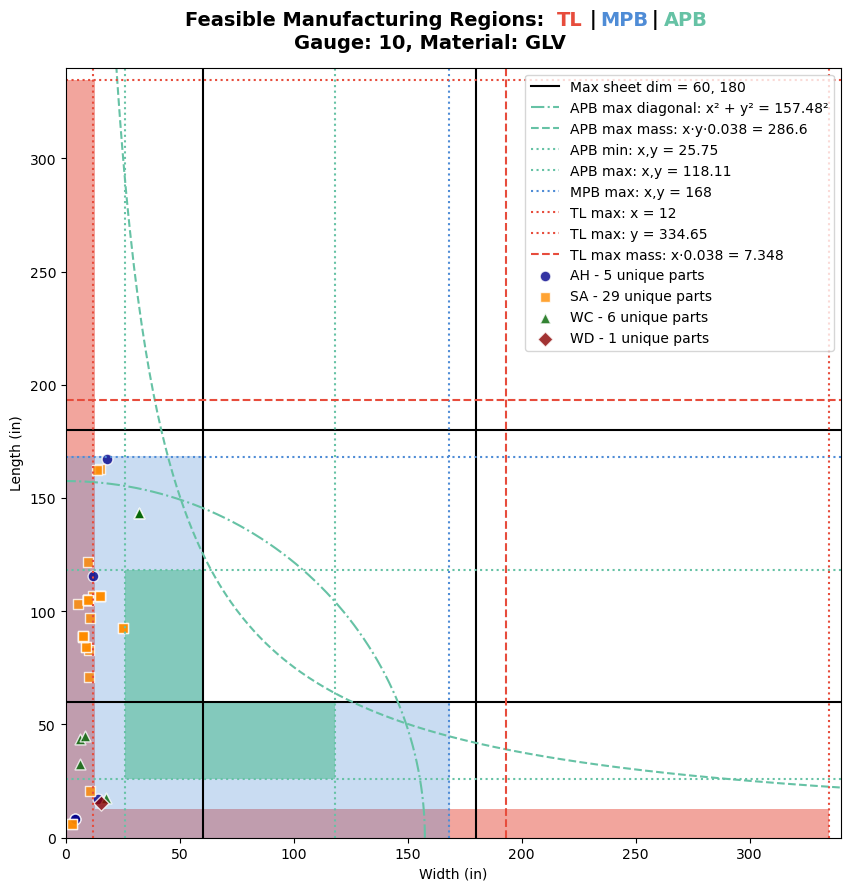

                                                        AH
total_parts                                              4
unique_part_counts           {'TL': 3, 'MPB': 1, 'APB': 0}
total_weight                                        288.41
weight_counts       {'TL': 86.03, 'MPB': 202.38, 'APB': 0}
                                                        SA
total_parts                                             21
unique_part_counts          {'TL': 15, 'MPB': 6, 'APB': 0}
total_weight                                        1994.7
weight_counts       {'TL': 1464.3, 'MPB': 530.4, 'APB': 0}
                                                     WC
total_parts                                           5
unique_part_counts        {'TL': 0, 'MPB': 5, 'APB': 0}
total_weight                                    1311.54
weight_counts       {'TL': 0, 'MPB': 1311.54, 'APB': 0}
                                                   WD
total_parts                                         1
unique_part_counts    

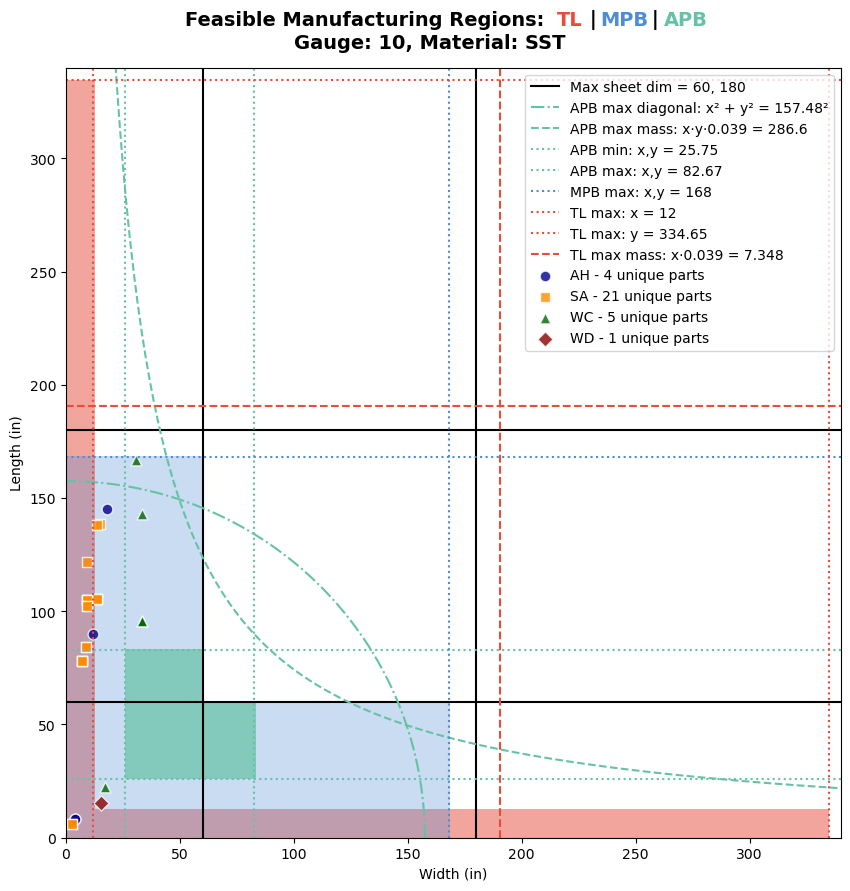

                                                    AH
total_parts                                          7
unique_part_counts       {'TL': 7, 'MPB': 0, 'APB': 0}
total_weight                                    209.23
weight_counts       {'TL': 209.23, 'MPB': 0, 'APB': 0}
                                                        SA
total_parts                                             10
unique_part_counts           {'TL': 9, 'MPB': 1, 'APB': 0}
total_weight                                        236.64
weight_counts       {'TL': 173.68, 'MPB': 62.95, 'APB': 0}
                                                              WC
total_parts                                                   21
unique_part_counts                {'TL': 4, 'MPB': 10, 'APB': 7}
total_weight                                              2723.4
weight_counts       {'TL': 93.73, 'MPB': 1747.63, 'APB': 882.04}
                                                    WD
total_parts                                       

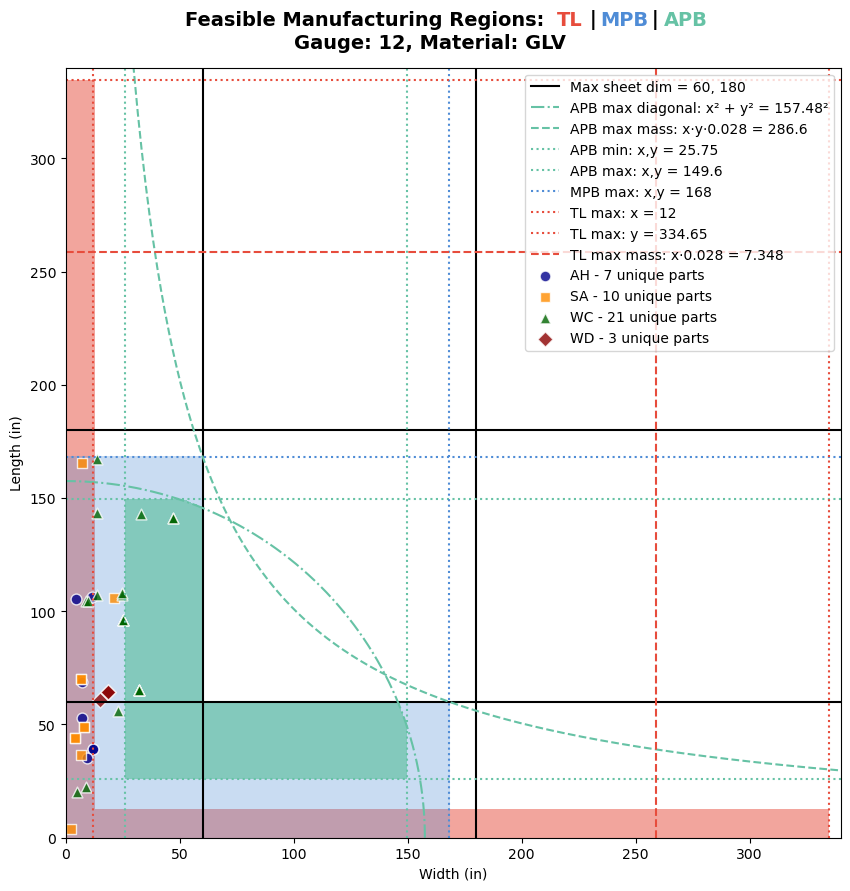

                                                   AH
total_parts                                         1
unique_part_counts      {'TL': 1, 'MPB': 0, 'APB': 0}
total_weight                                    57.57
weight_counts       {'TL': 57.57, 'MPB': 0, 'APB': 0}
                                                    SA
total_parts                                          7
unique_part_counts       {'TL': 7, 'MPB': 0, 'APB': 0}
total_weight                                    147.39
weight_counts       {'TL': 147.39, 'MPB': 0, 'APB': 0}
                                                    WC
total_parts                                          2
unique_part_counts       {'TL': 0, 'MPB': 2, 'APB': 0}
total_weight                                    692.08
weight_counts       {'TL': 0, 'MPB': 692.08, 'APB': 0}
                                                    WD
total_parts                                          2
unique_part_counts       {'TL': 0, 'MPB': 2, 'APB': 0}
total_weight   

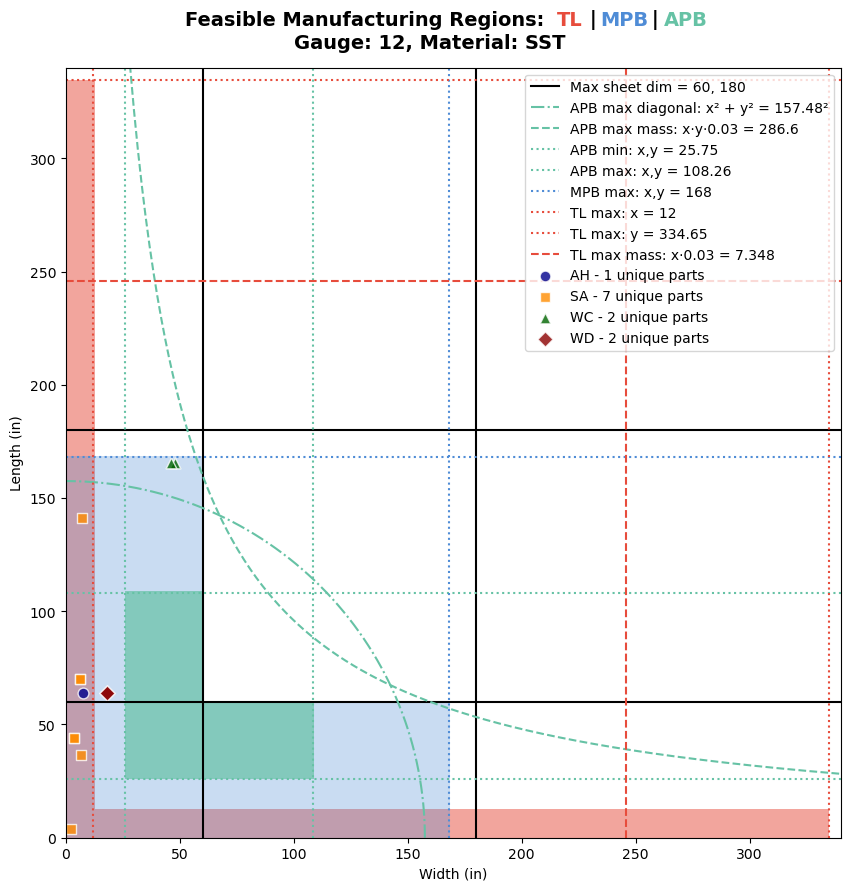

                                                        AH
total_parts                                              3
unique_part_counts           {'TL': 2, 'MPB': 0, 'APB': 1}
total_weight                                        177.35
weight_counts       {'TL': 101.94, 'MPB': 0, 'APB': 75.42}
                                                   SA
total_parts                                         5
unique_part_counts      {'TL': 5, 'MPB': 0, 'APB': 0}
total_weight                                    231.5
weight_counts       {'TL': 231.5, 'MPB': 0, 'APB': 0}
                                                        WC
total_parts                                              8
unique_part_counts           {'TL': 1, 'MPB': 0, 'APB': 7}
total_weight                                       1075.07
weight_counts       {'TL': 1.73, 'MPB': 0, 'APB': 1073.34}
                                                              WD
total_parts                                                   26
unique_par

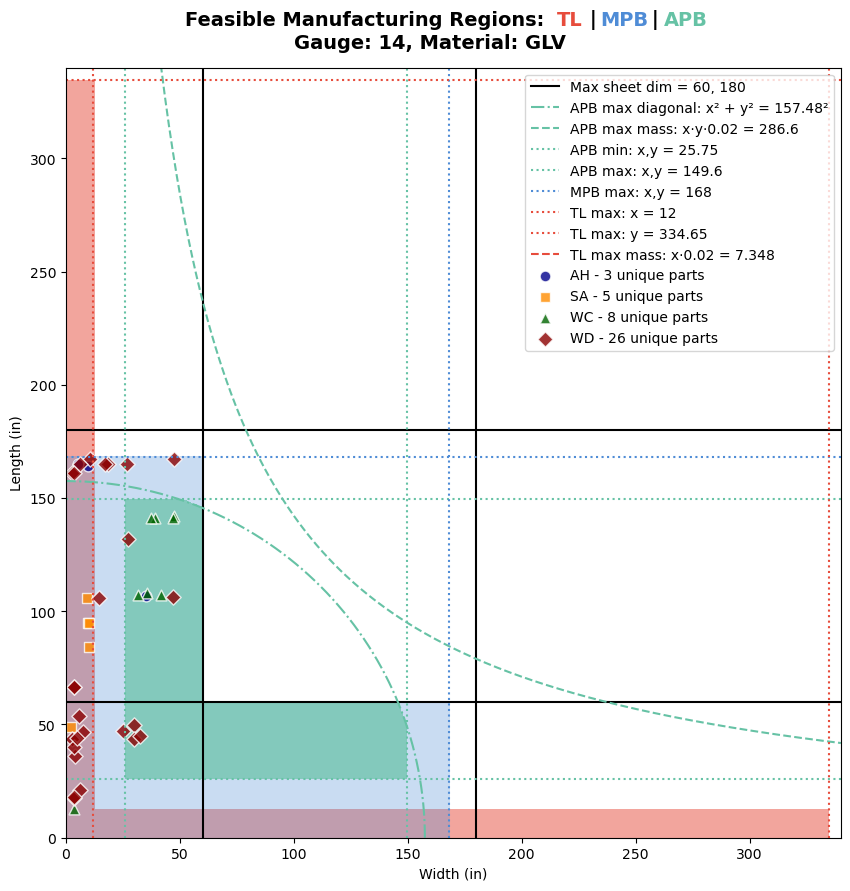

                                                   AH
total_parts                                         1
unique_part_counts      {'TL': 1, 'MPB': 0, 'APB': 0}
total_weight                                    64.96
weight_counts       {'TL': 64.96, 'MPB': 0, 'APB': 0}
                                                    SA
total_parts                                          3
unique_part_counts       {'TL': 3, 'MPB': 0, 'APB': 0}
total_weight                                    219.71
weight_counts       {'TL': 219.71, 'MPB': 0, 'APB': 0}
                                                     WC
total_parts                                           4
unique_part_counts        {'TL': 0, 'MPB': 4, 'APB': 0}
total_weight                                    1137.42
weight_counts       {'TL': 0, 'MPB': 1137.42, 'APB': 0}
                                                             WD
total_parts                                                  13
unique_part_counts                {'TL': 7, 'MP

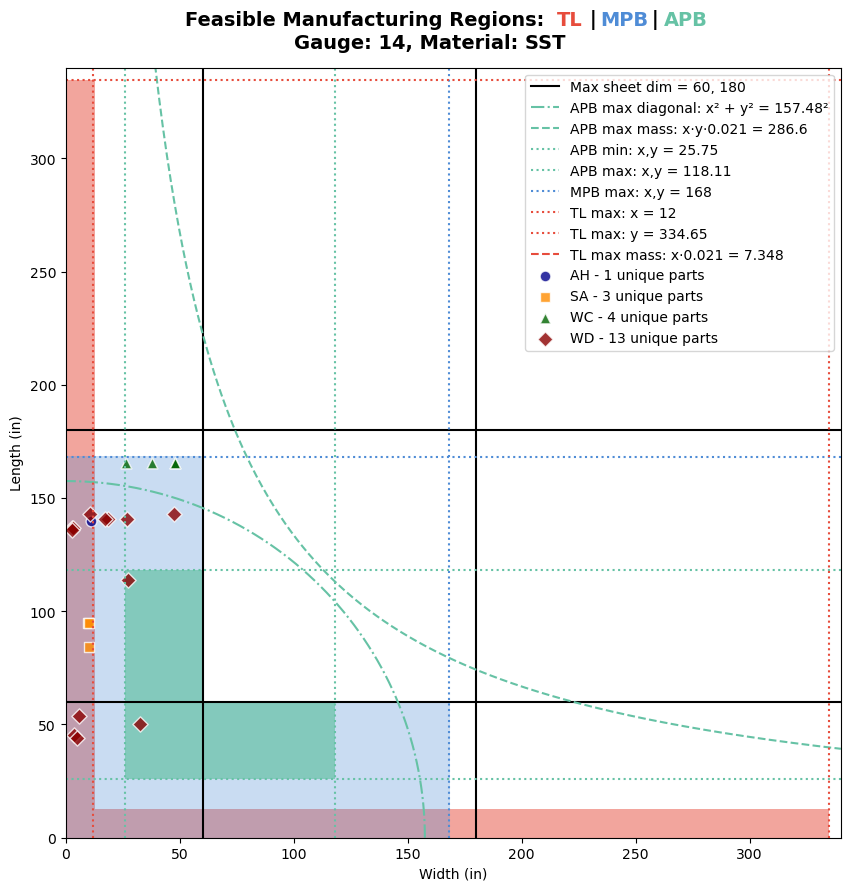

                                                       AH
total_parts                                             3
unique_part_counts          {'TL': 1, 'MPB': 0, 'APB': 2}
total_weight                                       255.05
weight_counts       {'TL': 6.37, 'MPB': 0, 'APB': 248.68}
                                                              SA
total_parts                                                   25
unique_part_counts                {'TL': 6, 'MPB': 5, 'APB': 14}
total_weight                                             1468.99
weight_counts       {'TL': 63.41, 'MPB': 106.45, 'APB': 1299.13}
                                                  WC
total_parts                                        1
unique_part_counts     {'TL': 1, 'MPB': 0, 'APB': 0}
total_weight                                    6.18
weight_counts       {'TL': 6.18, 'MPB': 0, 'APB': 0}


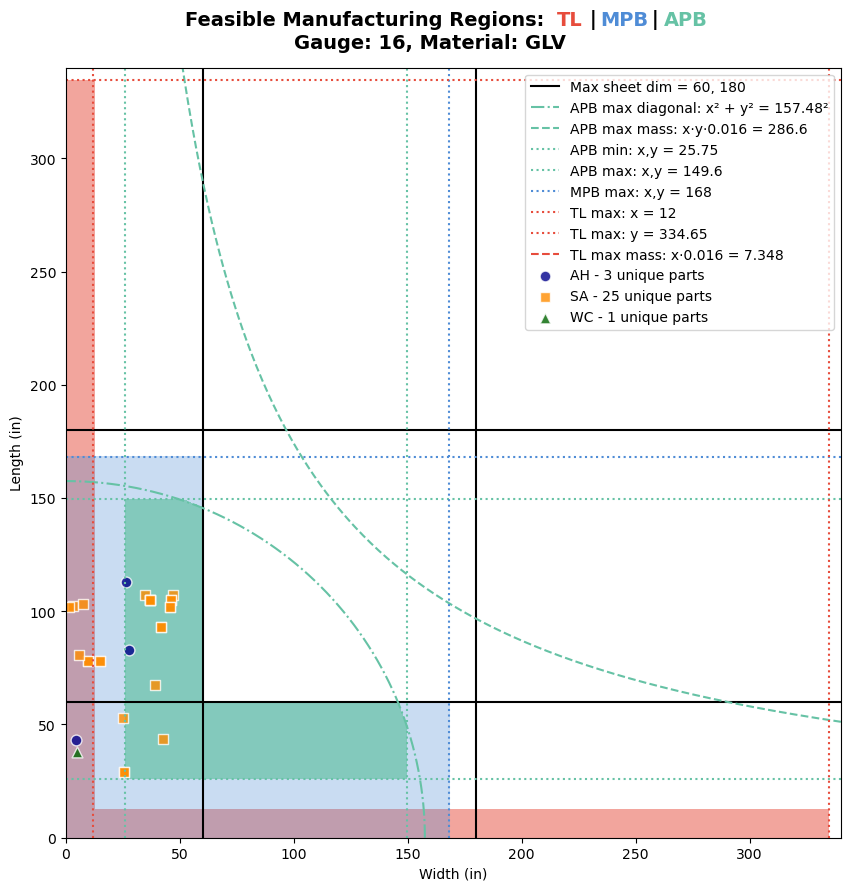

                                                            AH
total_parts                                                  3
unique_part_counts               {'TL': 1, 'MPB': 1, 'APB': 1}
total_weight                                            262.18
weight_counts       {'TL': 26.02, 'MPB': 30.42, 'APB': 205.74}
                                                    SA
total_parts                                          9
unique_part_counts       {'TL': 0, 'MPB': 0, 'APB': 9}
total_weight                                    872.39
weight_counts       {'TL': 0, 'MPB': 0, 'APB': 872.39}


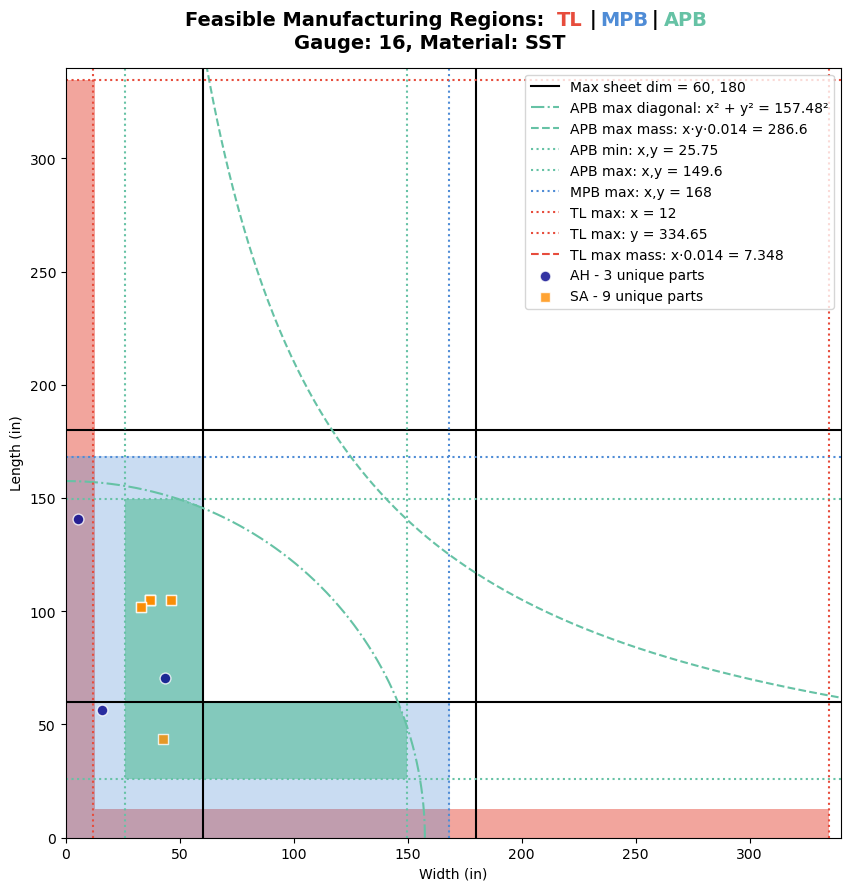

In [5]:
gauges = [8, 10, 12, 14, 16]
materials = ['GLV', 'SST']

# Plot all combinations
for gauge in gauges:
    for material in materials:
        cap = Capabilities(material, gauge)
        cap.plot_feasible_regions()
        part_set_stats = cap.add_part_sets(part_sets, get_stats=True)
        get_part_stats(part_set_stats)

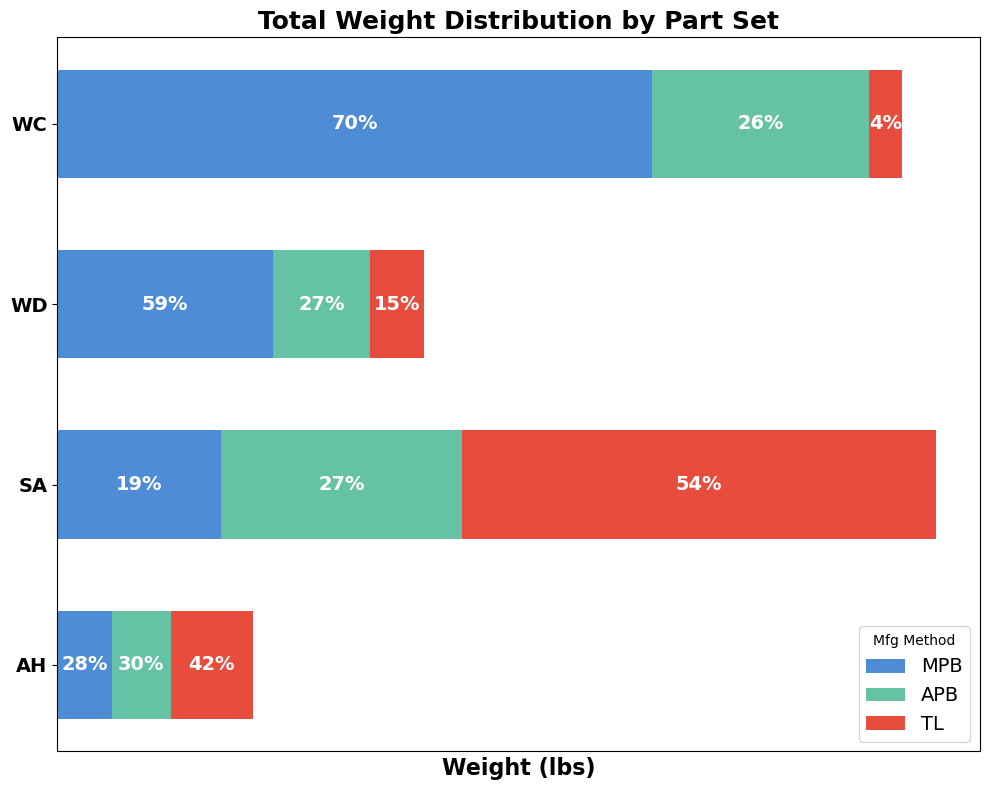

In [12]:
# for submodule in all_stats.keys():
#     if all_stats[submodule]['total_parts'] == 0:
#         continue
#     plot_pie_chart(all_stats[submodule]['weight_counts'], f'Weight in {submodule}')

# Plot the total weight distribution for each part set
plot_stacked_bar_chart(all_stats, 'Total Weight Distribution by Part Set')

In [7]:
for app in xw.apps:
    app.quit()

# Diagonal increase from (40,30) to (100,80)
# cap = Capabilities('GLV', 10)
# results = cap.plot_cost_run_chart(path, 5, 5, 55, 55, 'diagonal', 5)

# gauges = [8, 10, 12, 14, 16]
# materials = ['GLV', 'SST']
# for gauge in gauges:
#     for material in materials:
#         cap = Capabilities(material, gauge)
#         cap.plot_individual_cost_heatmap(path, fastener_spacing=3, bolt_diameter=0.3125)
#         cap.plot_optimal_cost_heatmap(path, fastener_spacing=3, bolt_diameter=0.3125)
#         cap.plot_cost_difference_heatmap(path, fastener_spacing=3, bolt_diameter=0.3125)